In [1]:
%matplotlib inline

In [ ]:
import sys
import pandas as pd
import numpy.matlib
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import statsmodels
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')

The full model with covariate correction is not used here (will be added soon), rather a simple ridge correction is applied instead, the results are similar though slightly less powered

In [3]:
def Zcells(DGE):
    """Z transformation of columns of pandas"""
    DGEZ=DGE.copy()
    DGEZ=pd.DataFrame(sklearn.preprocessing.scale(DGE,axis=0))
    DGEZ.index=DGE.index
    DGEZ.columns=DGE.columns
    return DGEZ

In [4]:
def run_ridge(Y,X):
    lm=linear_model.Ridge(fit_intercept=True,max_iter=10000)
    lm.fit(X,Y)
    B=pd.DataFrame(lm.coef_)
    B.index=Y.columns
    B.columns=X.columns
    return B    

In [5]:
def shuffle_mat(X,Xother,Y):
    flag=0
    X_shuffle=X.copy()
    X_shuffle.index=np.random.permutation(X.index)
    X_shuffle=X_shuffle.loc[Y.index]
    XF_shuffle=pd.concat([X_shuffle,Xother],axis=1)
        
    return XF_shuffle

In [6]:
def make_shufs(X,Xother,Y,shufnum=3):
    Be_shuffs=pd.DataFrame()
    flag=0
    for i in range(shufnum):
        XF_shuffle=shuffle_mat(X,Xother,Y)
        from sklearn import linear_model
        lm=linear_model.Ridge(fit_intercept=True,max_iter=10000)
        lm.fit(XF_shuffle,Y)
        Be_shuf=pd.DataFrame(lm.coef_)
        Be_shuf.index=Y.columns
        Be_shuf.columns=XF_shuffle.columns
        if flag==0:
            Be_shuffs=Be_shuf
            flag=1
        else:
            Be_shuffs=pd.concat([Be_shuffs,Be_shuf])
    return Be_shuffs

In [7]:
def fdr_colwise_coefs(B,B_shuf):

    BFDR=B.copy()

    for col in BFDR.columns:
        
        curcol=B[col]
        curfdr=BFDR[col]
        curecdf=ECDF(B_shuf[col])

        curcol_pos=curcol>0
        curcol_neg=curcol<0
        sign_col=np.sign(curcol)

        curfdr[curcol_pos]=-np.log10(statsmodels.sandbox.stats.multicomp.fdrcorrection0(1.0-curecdf(curcol[curcol_pos]))[1])
        curfdr[curcol_neg]=np.log10(statsmodels.sandbox.stats.multicomp.fdrcorrection0(curecdf(curcol[curcol_neg]))[1])

        BFDR[col]=curfdr

    return BFDR

In [8]:
PATH2DATA='CHANGETHIS'
DGE=pd.read_csv(PATH2DATA+'scOSTKO_Pilot.txt.gz',sep='\t',index_col=0)

In [9]:
DGE.head()

,ATTAACGTGAGN.1,GCTAAGCTTACA.1,CCGATATTAACT.1,CCATTACGCTGA.1,GCGTAGGCCGAA.1,AAACGCTCCTTA,GAAGATTGGTCN.1,TCCCACGCACTN,TTAAGTAGCAGG,CTTTCACTTATC.1,...,CCCACGTTGTCT,GACAACGTTCCT,GCCACCCTAGGT,TTCACAAGCTTC,TAATATTCTTTC,TTGGAGCGTCCA,GCTCGATTTTTC,TACACTGAGGCA,CATGGCTTATTC,GATCGTAGACCC
0610007P14Rik,0.000000,0.000000,0.000000,0.000000,5.992506,6.218901,0.000000,6.390448,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
0610009D07Rik,7.415441,0.000000,7.406524,6.957206,6.981132,0.000000,7.476932,8.377492,7.005285,8.272240,...,9.899198,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8.674772,0.000000
0610031J06Rik,6.423868,0.000000,6.825807,7.951389,7.562283,0.000000,5.908076,7.381824,0.000000,0.000000,...,0.000000,0.0,0.0,8.755623,0.0,0.0,0.0,0.0,9.673005,8.817776
1100001G20Rik,9.316121,6.998368,0.000000,10.646889,6.981132,7.790893,5.908076,7.381824,7.005285,0.000000,...,9.899198,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8.674772,0.000000
1110001A16Rik,5.440574,7.579564,7.406524,5.968770,5.992506,7.209184,6.896013,0.000000,0.000000,6.286171,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [10]:
labels=pd.read_csv(PATH2DATA+'scOSTKO_labels.txt',sep='\t',index_col=0)

In [11]:
#signature genes, if desired
heat_shock_genes=['Hspa5','Pdia6','Hsp90b1','Dnajc3','Pdia3','Calr','Manf','Hyou1','Herpud1','Pdia4','Dnajb11']
downregulated_genes=['Tnf','Osm','Cxcl1','Il1a']

In [12]:
Y=DGE.T

In [13]:
X=labels
X.index=Y.index
X['Perturbation']=[0 if 'WT' in x else 1 for x in list(X['Perturbation'])]

# Genes Detected use here
X['qc']=Zcells(pd.DataFrame((Y>0).sum(axis=1)))

In [14]:
X.head()

,Perturbation,qc
ATTAACGTGAGN.1,1,4.850114
GCTAAGCTTACA.1,1,3.372727
CCGATATTAACT.1,1,4.274093
CCATTACGCTGA.1,1,3.220721
GCGTAGGCCGAA.1,1,3.666071


In [15]:
print('Knockout cells = '+str(np.sum(labels['Perturbation']==1))+', Wildtype cells= '+str(np.sum(labels['Perturbation']==0)))

Knockout cells = 706, Wildtype cells= 424


In [21]:
#Simple Linear Model Calculation of Differential Expression
Be=run_ridge(Y,X)
Be_shufs=make_shufs(pd.DataFrame(X['Perturbation']),pd.DataFrame(X['qc']),Y,shufnum=10)

In [22]:
BFDR=fdr_colwise_coefs(Be,Be_shufs)

In [23]:
ost_de=pd.read_csv(PATH2DATA+'ost_vs_NT_T2.csv',index_col=0)
ost_de['sl10']=np.sign(ost_de['log2FoldChange'])*-np.log10(ost_de['padj'])
print(len(ost_de))

23366


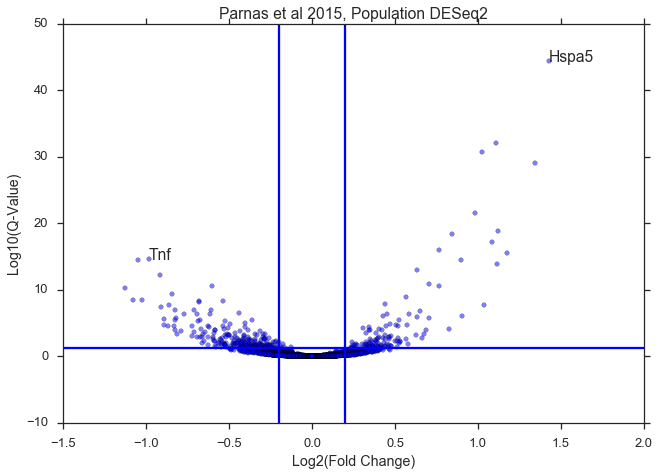

In [24]:
plt.scatter(ost_de['log2FoldChange'],np.abs(ost_de['sl10']),alpha=0.5)
plt.annotate('Tnf',(ost_de.loc['Tnf']['log2FoldChange'],np.abs(ost_de.loc['Tnf']['sl10'])))
plt.annotate('Hspa5',(ost_de.loc['Hspa5']['log2FoldChange'],np.abs(ost_de.loc['Hspa5']['sl10'])))
plt.axvline(0.2)
plt.axvline(-0.2)
plt.axhline(1.3)
plt.title('Parnas et al 2015, Population DESeq2')
plt.xlabel('Log2(Fold Change)')
plt.ylabel('Log10(Q-Value)')

In [25]:
COMBINED_TABLE=BFDR.join(ost_de).dropna()

In [26]:
max_cap=20
COMBINED_TABLE.ix[COMBINED_TABLE['Perturbation']>max_cap,'Perturbation']=max_cap
COMBINED_TABLE.ix[COMBINED_TABLE['Perturbation']<-max_cap,'Perturbation']=-max_cap
COMBINED_TABLE.ix[COMBINED_TABLE['sl10']>max_cap,'sl10']=max_cap
COMBINED_TABLE.ix[COMBINED_TABLE['sl10']<-max_cap,'sl10']=-max_cap

243


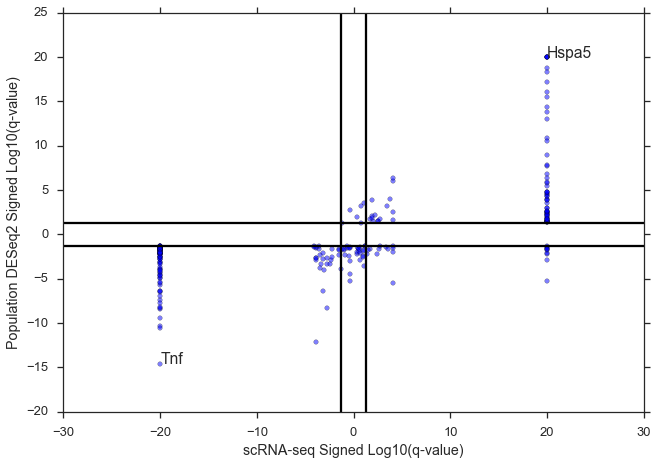

In [27]:
sig_thresh=1.3
pop_sigs=COMBINED_TABLE['sl10'].abs()>sig_thresh
print(np.sum(pop_sigs))
plt.scatter(COMBINED_TABLE['Perturbation'][pop_sigs],COMBINED_TABLE['sl10'][pop_sigs],alpha=0.5)
plt.annotate('Tnf',(COMBINED_TABLE.loc['Tnf']['Perturbation'],COMBINED_TABLE.loc['Tnf']['sl10']))
plt.annotate('Hspa5',(COMBINED_TABLE.loc['Hspa5']['Perturbation'],COMBINED_TABLE.loc['Hspa5']['sl10']))
plt.axvline(sig_thresh,c='black')
plt.axvline(-sig_thresh,c='black')
plt.axhline(sig_thresh,c='black')
plt.axhline(-sig_thresh,c='black')
plt.xlabel('scRNA-seq Signed Log10(q-value)')
plt.ylabel('Population DESeq2 Signed Log10(q-value)')

In [28]:
#Concordance between population RNA-seq and scRNA-seq 
np.mean(np.sign(COMBINED_TABLE[pop_sigs]['sl10'])==np.sign(COMBINED_TABLE[pop_sigs]['Perturbation']))

0.83539094650205759

In [29]:
cellvec=np.round(np.linspace(5,200,12))
cellvec_sig=np.round(np.linspace(2,60,22))
wtcells=X[X['Perturbation']==0].index
ostcells=X[X['Perturbation']==1].index

In [30]:
sig_poptot=ost_de[np.abs(ost_de['sl10'])>1.3].index

In [31]:
genes_detected=(Y>0).sum()

In [32]:
these_genes=Y.columns[genes_detected>100]

In [33]:
ost_de=ost_de.loc[list(ost_de.index.intersection(these_genes))]

In [34]:
sig_popsub=ost_de[np.abs(ost_de['sl10'])>1.3].index

In [35]:
(len(ost_de),np.sum(ost_de['sl10']>1.3),np.sum(ost_de['sl10']<(-1.3)))

(3824, 82, 158)

In [ ]:
#evaluate the significance of the heatshock signature as a function of cells

MULTI_hs=[]
for j in range(10):
    DOWNSAMPLE=[]
    print(j)
    for i in range(len(cellvec_sig)):
        thesecells=[]
        theseostcells=np.random.choice(ostcells,int(cellvec_sig[i]),replace=False)
        thesecells.extend(wtcells)
        thesecells.extend(theseostcells)
        Xsample=X.loc[thesecells]
        Ysample=Y.loc[thesecells]
        Be_nocells=run_ridge(Ysample,Xsample)
        Be_shufs=make_shufs(pd.DataFrame(Xsample['Perturbation']),pd.DataFrame(Xsample['qc']),Ysample,shufnum=5)
        BFDR=fdr_colwise_coefs(Be_nocells,Be_shufs)
        BFDR_hs=BFDR.loc[heat_shock_genes]['Perturbation']
        
        #set maximum limits on p-value
        BFDR_hs[BFDR_hs<0]=0
        BFDR_hs[BFDR_hs>4]=4
        #use Fisher's combined p-value method to evaluate the significance of a signature
        DOWNSAMPLE.append(-np.log10(scipy.stats.combine_pvalues(np.power(10,-BFDR_hs))[1]))
    MULTI_hs.append(DOWNSAMPLE)
 

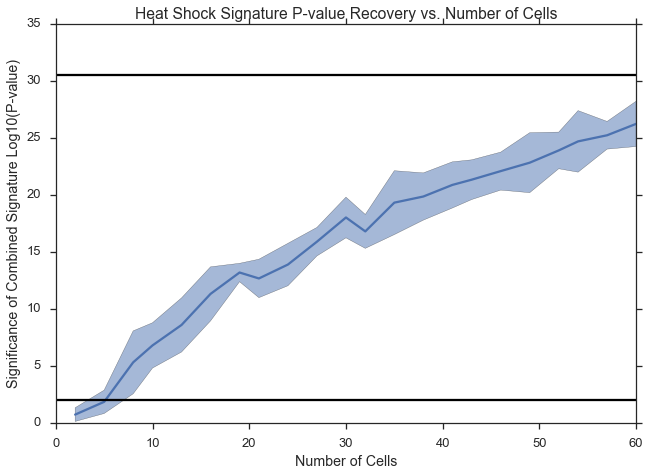

In [38]:
#plot P-values vs. Number of Cells

df_hs=pd.DataFrame(MULTI_hs)
y=np.array(df_hs.mean(axis=0))
ystd=np.array(df_hs.std(axis=0))
plt.plot(cellvec_sig,y)
plt.fill_between(cellvec_sig, y-ystd, y+ystd,alpha=0.5)

plt.axhline(2,c='black')
#maximum p-value
plt.axhline(-np.log10(scipy.stats.combine_pvalues([1e-4]*len(heat_shock_genes))[1]),c='black')
plt.title('Heat Shock Signature P-value Recovery vs. Number of Cells')
plt.xlabel('Number of Cells')
plt.ylabel('Significance of Combined Signature Log10(P-value)')

In [39]:
pop_thresh=2
sc_thresh=3

In [68]:
#Perform independent downsamplings
niter=10

MULTI_tp=pd.DataFrame(np.zeros((niter,len(cellvec))))

for j in range(niter):
    DOWNSAMPLE=pd.DataFrame()
    print(j)
    for i in range(len(cellvec)):
        infovec=[]
        thesecells=[]
        theseostcells=np.random.choice(ostcells,int(cellvec[i]),replace=False)
        thesewtcells=np.random.choice(wtcells,int(cellvec[i]),replace=False)
        thesecells.extend(thesewtcells)
        thesecells.extend(theseostcells)
        Xsample=X.loc[thesecells]
        Ysample=Y.loc[thesecells]
        Be_nocells=run_ridge(Ysample,Xsample)
        Be_shufs=make_shufs(pd.DataFrame(Xsample['Perturbation']),pd.DataFrame(Xsample['qc']),Ysample,shufnum=10)
        BFDR=fdr_colwise_coefs(Be_nocells,Be_shufs)
        BIG_TABLE=BFDR.join(ost_de).dropna()

        pop_pos=BIG_TABLE['sl10']>pop_thresh
        pop_neg=BIG_TABLE['sl10']<(-pop_thresh)
        sc_pos=BIG_TABLE['Perturbation']>sc_thresh
        sc_neg=BIG_TABLE['Perturbation']<-sc_thresh

        tpr=np.divide(1.0*np.sum(np.logical_and(pop_pos,sc_pos))+np.sum(np.logical_and(pop_neg,sc_neg)),np.sum(pop_pos)+np.sum(pop_neg))
        
        DOWNSAMPLE[i]=[tpr]
       
        df_effectsize=pd.concat([df_effectsize,tmpeffect])
        
    MULTI_tp.ix[j,:]=np.array(DOWNSAMPLE)

0
1
2
3
4
5
6
7
8
9


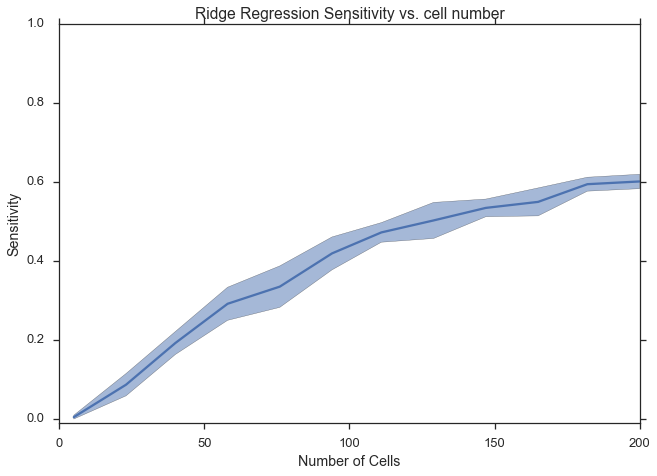

In [70]:
y=np.array(MULTI_tp.mean(axis=0))
ystd=np.array(MULTI_tp.std(axis=0))
plt.plot(cellvec,y)
plt.fill_between(cellvec, y-ystd, y+ystd,alpha=0.5)

plt.ylim([-0.01,1.0])
plt.xlabel('Number of Cells')
plt.ylabel('Sensitivity')
plt.title('Ridge Regression Sensitivity vs. cell number')